In [1]:
import os
import sys
work_dir = '/home/abhijit/nat/Object-Detection'
data_dir = work_dir+'/data/'
util_dir = work_dir+'/data_utilities/'
os.chdir(work_dir)
sys.path.append(util_dir)
sys.path.append(data_dir)

import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
from PIL import Image, ImageDraw 
from tqdm import tqdm
import pickle
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from matplotlib.lines import Line2D
import pandas as pd
from read_write import *
import shutil
from torch.utils.data import random_split

In [2]:
#Loading our labels
coords, chips, classes = wv.get_labels(data_dir+'xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 186913.46it/s]


In [3]:
labels = {}
with open(util_dir+'xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

valid_labels = list(labels.keys())

In [4]:
valid_chip_names = load("valid_chip_names.pkl")

id2label = load("id_label_map.pkl")

label2id = {v:k for k,v in id2label.items()}

len(id2label)

60

In [5]:
def label2idx(labels):
    return {label:label2id[label] for label in labels}

In [6]:
label2idx(['Pickup Truck','Truck Tractor','Truck w/Flatbed','Truck w/Liquid'])

{'Pickup Truck': '20',
 'Truck Tractor': '26',
 'Truck w/Flatbed': '28',
 'Truck w/Liquid': '29'}

In [7]:
unique, counts = np.unique(classes, return_counts=True)
class_counts = {k:0 for k in list(unique.astype('int64'))}

In [19]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])

dataset = ImageFolder(data_dir+'train_images_24classes/',transform=transform,)

trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

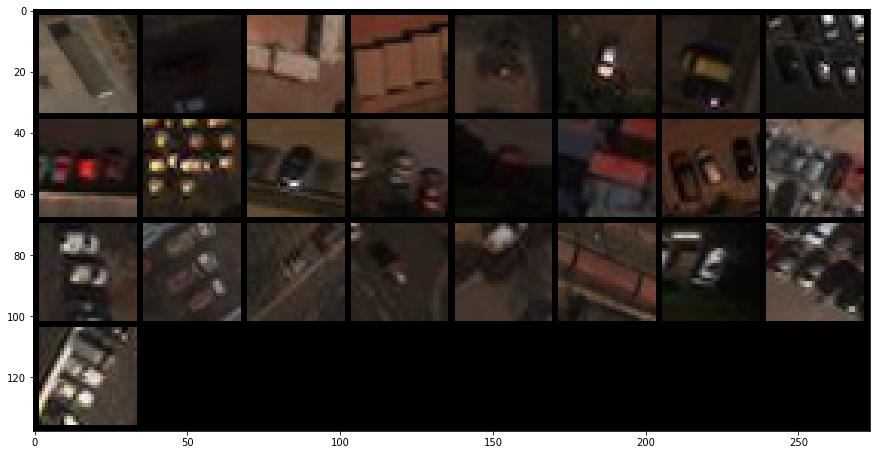

In [20]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[15,10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(img_grid)

In [9]:
train_size = 0.7*len(dataset)
val_size = 0.3*len(dataset)
print("full size",len(dataset))
print("train size",train_size)
print("val size",val_size)
189829+81355

full size 271184
train size 189828.8
val size 81355.2


271184

In [21]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def plot_classes_preds(images, labels):
    
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        ax.set_title(id2label[idx_to_class[labels[idx].item()]])
        matplotlib_imshow(images[idx])
    return fig
#writer = SummaryWriter('runs/Object_detection_experiment_'+str(np.random.randint(0,1000)),flush_secs=1)
#writer.add_figure('Images and labels', plot_classes_preds(images, labels))

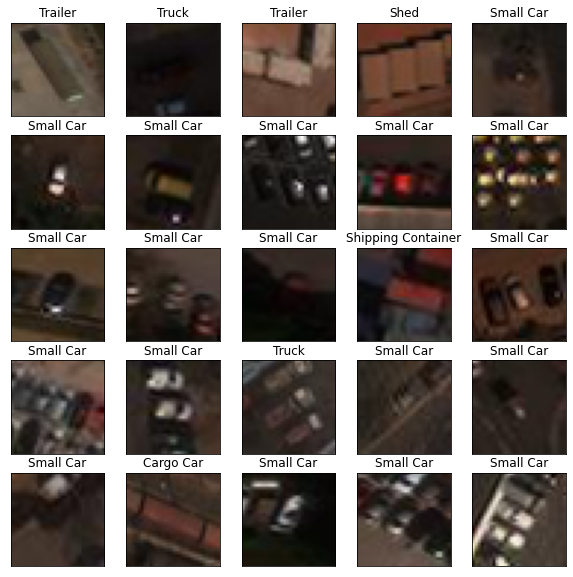

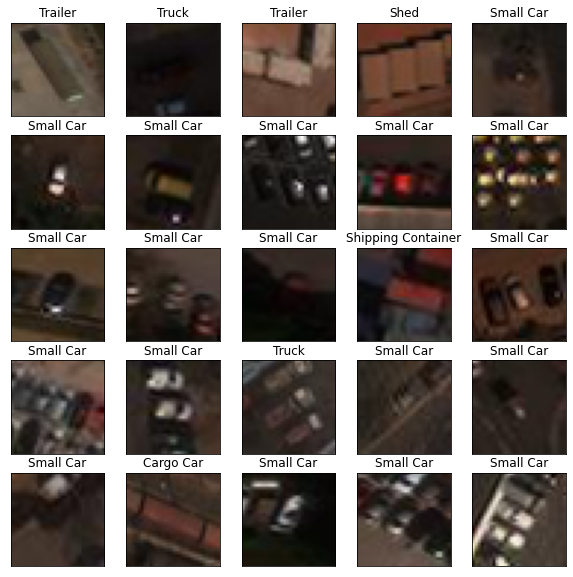

In [22]:
plot_classes_preds(images, labels)

In [107]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_24classes/'):
    if len(files)>0:
        print(f'{id2label.get(subdir[-2:],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

              Cargo Truck       5852
              Vehicle Lot       3185
                Cargo Car       1820
             Pickup Truck       1096
              Truck w/Box       3591
                     Shed       1145
         Damaged Building       1026
               Dump Truck       1351
                 Hut/Tent        703
                      Bus       6892
            Passenger Car       1596
                Small Car     210497
             Storage Tank       1609
       Shipping Container       1574
            Truck Tractor        856
        Passenger Vehicle       2932
           Fishing Vessel        729
   Shipping container lot       1809
                Motorboat       1455
            Utility Truck       3598
          Truck w/Flatbed        887
                  Trailer       4057
                Excavator        836
                    Truck      12088
271184


In [37]:
class_counts['Truck w/Liquid']

147

In [63]:
c_count = pd.DataFrame(list(class_counts.values()))
c_count[c_count[0]>700].values[1:]
small_subset_class = {}
a = 0
for label, count in class_counts.items():
    
    if count > 700 and count < 250000:
        small_subset_class[label] = count
        #print(label,count)
        a+=count
print("total",a)
print(small_subset_class)
print("total confirm",sum(list(small_subset_class.values())))
print("len",len(small_subset_class))
#save('class_counts_24classes.pkl',small_subset_class)

total 271184
{'Cargo Truck': 5852, 'Vehicle Lot': 3185, 'Cargo Car': 1820, 'Pickup Truck': 1096, 'Truck w/Box': 3591, 'Shed': 1145, 'Damaged Building': 1026, 'Dump Truck': 1351, 'Hut/Tent': 703, 'Bus': 6892, 'Passenger Car': 1596, 'Small Car': 210497, 'Storage Tank': 1609, 'Shipping Container': 1574, 'Truck Tractor': 856, 'Passenger Vehicle': 2932, 'Fishing Vessel': 729, 'Shipping container lot': 1809, 'Motorboat': 1455, 'Utility Truck': 3598, 'Truck w/Flatbed': 887, 'Trailer': 4057, 'Excavator': 836, 'Truck': 12088}
total confirm 271184
len 24


In [72]:
new_classes = load('class_counts_24classes.pkl')
#os.mkdir(data_dir+'train_images_24classes')
# for i in list(new_classes.keys()):
#     os.mkdir(data_dir+'train_images_24classes/'+str(int(label2id[i])))

In [119]:
f = data_dir+'new_train_images_filtered/'
t = data_dir+'train_images_24classes/'
valid_c = list(new_classes.keys())
count1 = 0
for subdir, dirs, files in os.walk(data_dir+'new_train_images_filtered/'):
    a = subdir[-2:]
    if id2label.get(a,-1) in valid_c:
        for filename in files:
            #print(subdir+os.sep+filename)
            shutil.copy(subdir+os.sep+filename,t+os.sep+a)
            count1+=1
print("total count sanity", count1)

total count sanity 271184


In [78]:
a

'23'

In [67]:
label2id

{'Fixed-wing Aircraft': '11',
 'Small Aircraft': '12',
 'Cargo Plane': '13',
 'Helicopter': '15',
 'Passenger Vehicle': '17',
 'Small Car': '18',
 'Bus': '19',
 'Pickup Truck': '20',
 'Utility Truck': '21',
 'Truck': '23',
 'Cargo Truck': '24',
 'Truck w/Box': '25',
 'Truck Tractor': '26',
 'Trailer': '27',
 'Truck w/Flatbed': '28',
 'Truck w/Liquid': '29',
 'Crane Truck': '32',
 'Railway Vehicle': '33',
 'Passenger Car': '34',
 'Cargo Car': '35',
 'Flat Car': '36',
 'Tank car': '37',
 'Locomotive': '38',
 'Maritime Vessel': '40',
 'Motorboat': '41',
 'Sailboat': '42',
 'Tugboat': '44',
 'Barge': '45',
 'Fishing Vessel': '47',
 'Ferry': '49',
 'Yacht': '50',
 'Container Ship': '51',
 'Oil Tanker': '52',
 'Engineering Vehicle': '53',
 'Tower crane': '54',
 'Container Crane': '55',
 'Reach Stacker': '56',
 'Straddle Carrier': '57',
 'Mobile Crane': '59',
 'Dump Truck': '60',
 'Haul Truck': '61',
 'Scraper/Tractor': '62',
 'Front loader/Bulldozer': '63',
 'Excavator': '64',
 'Cement Mixer

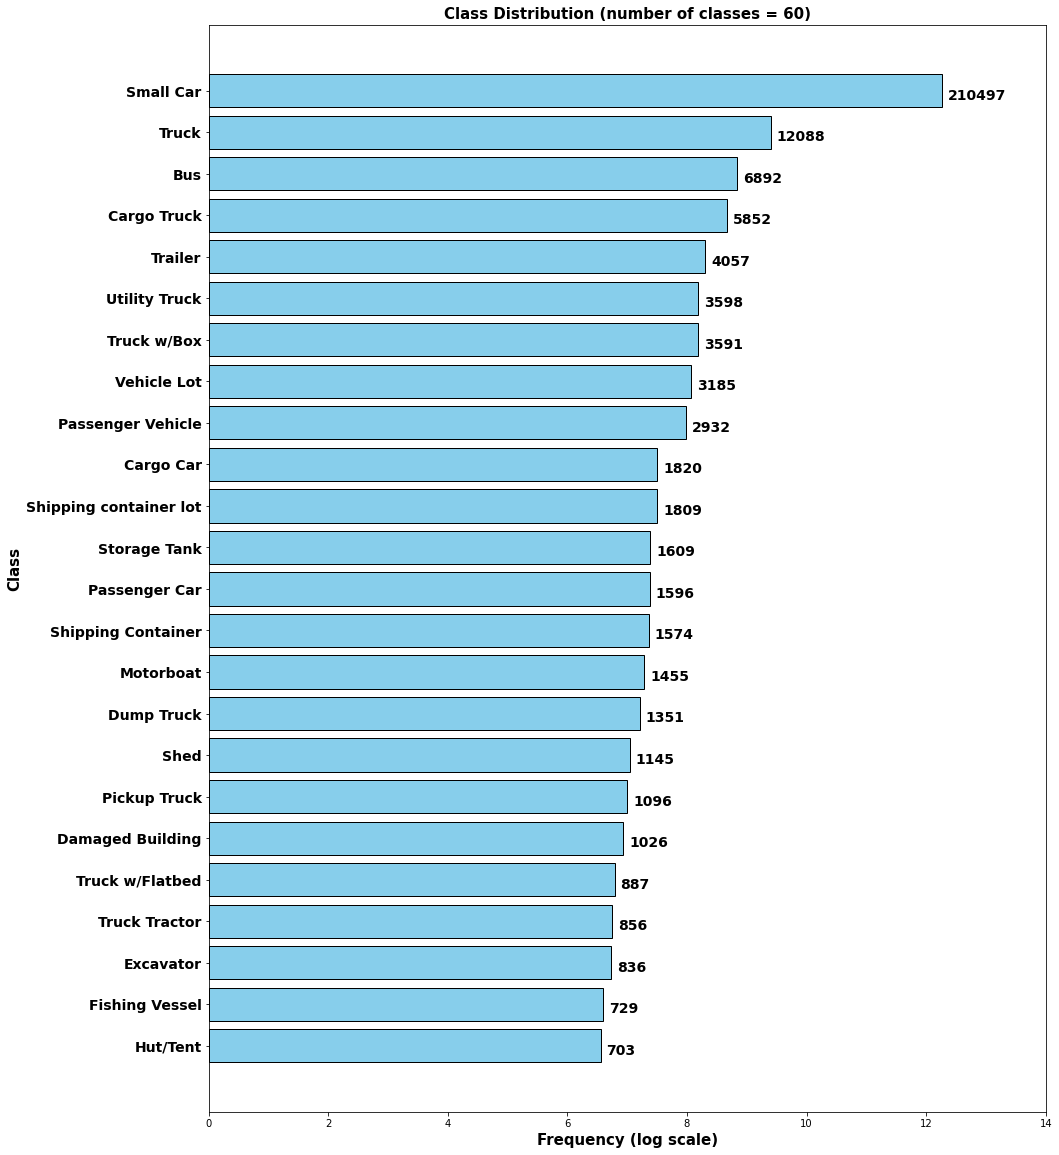

In [91]:
fig, ax = plt.subplots(figsize=[15,20])
class_counts = sorted(class_counts.items(), key=lambda class_counts: class_counts[1])
class_counts = {k: v for k, v in class_counts}
real_count = list(class_counts.values())
bars = plt.barh(list(class_counts.keys()), np.log(np.array(list(class_counts.values()))), edgecolor='k',color='skyblue')

for i,bar in enumerate(bars): 
    width = bar.get_width() +0.1
    label_y_pos = bar.get_y() + 0.2 + bar.get_height() // 2
    ax.text(width,label_y_pos, s=f'{real_count[i]}',fontweight='bold',fontdict={'fontsize':14})
    if i > 44:
        bar.set_color('#8f9805')
        bar.set_edgecolor('k')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')

custom_lines = [Line2D([0], [0], color='#8f9805', lw=4)]
#plt.legend(custom_lines,['Top 15 most frequent classes'],loc=5,fontsize='large')
plt.title('Class Distribution (number of classes = 60)',fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':15,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlim(0,14)

plt.show()

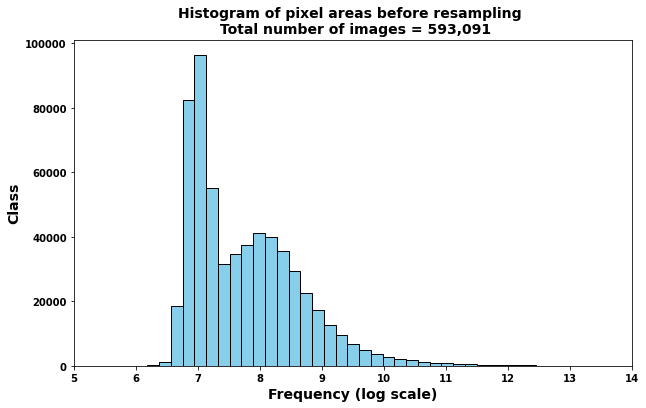

In [119]:
f = open('old_pixel_areas.pkl','rb')
old_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(old_pixel_areas)),bins=50,color='skyblue',ec="k")

plt.title('Histogram of pixel areas before resampling \n Total number of images = 593,091',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

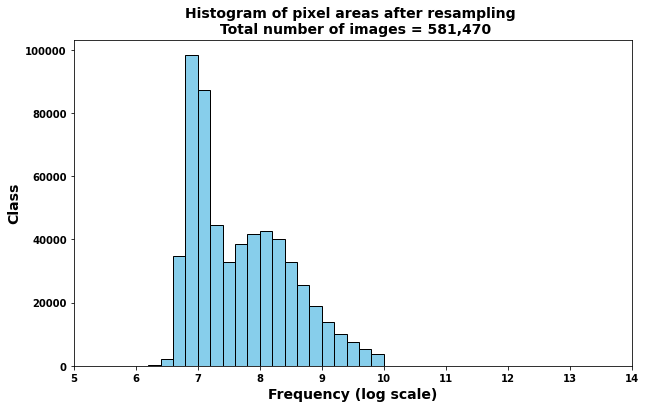

In [120]:
f = open('new_pixel_areas.pkl','rb')
new_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(new_pixel_areas)),bins=20,color='skyblue',ec="k")

plt.title('Histogram of pixel areas after resampling \n Total number of images = 581,470',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [ ]:
!mkdir ../backup_new_train_images_2/

In [ ]:
!cp -r ../new_train_images_2/ ../backup_new_train_images_2/

In [12]:
!rm -r data/new_train_images_filtered/

In [ ]:
!mkdir ../new_train_images_2

In [14]:
for i in list(unique.astype('int64')):
  os.mkdir(data_dir+'new_train_images/'+str(i))

In [10]:
!pwd

/home/abhijit/nat/Object-Detection


In [ ]:
!mkdir data/new_train_images

In [13]:
os.mkdir(data_dir+'new_train_images_filtered')
for i in list(id2label.keys()):
  os.mkdir(data_dir+'new_train_images_filtered/'+str(int(i)))

In [60]:
len(unique)

62

In [62]:
len(id2label.keys())

60

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import requests 
from tqdm import tqdm
file_url = ["https://d307kc0mrhucc3.cloudfront.net/train_images.tgz?Expires=1614387555&Signature=NBrilUhHPZgQPsWZLnt1z~qxZw3joeiA7X9wD0FxZBFdrwZgURgew0q2RJitOpwrs~DanTIpBESPz3kB6wvpD89-Xhyn9L3GxQioWSylbmkKHRKNdhCvmnwOsKuJ11vrBogBDdtilVlfnGeIT1e9ERh~fYkfKJQlpP8wEUJE3TVvSjSZ6yb7fpeq6XlQEgXiky7~wxYtr457D3c5fwLJdotnDFJAVU2rDnhevv4~PhLwDXFCdB5Fq-MLqCAn5gOAtZtuW643r~hluwiov9Xezhk2uvAaQeQJNwupl3DfFc4lbxYVaiXRP5-ApCi~U~cYq0D-BUqF3XxYDN4pRYXc7A__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ",
            "https://d307kc0mrhucc3.cloudfront.net/train_labels.tgz?Expires=1614387555&Signature=e~93prunA1dNTN22YV4-fJ4VOnFjWce1DiU2kLkmZkMu5UbEesBh5Hrqr9gRsF~6F6-hkoi-bGbDyGS2h7DZ9cAATbNV7Ka8ILgxl75xhR468e6Sahzo4IeJdJFhoJ4TNS~UoJX4s~mNjwhOAeJ-BhKr2nJ~aB9G1iRV-MNi0Q~ibtHxv3We7KWG3p9PNM-4nnOTGnKK9OwTlhMesXBnkk206ahOJVidlfL3-XlaW6zQiPHeAX4X-BA8xHbcR5JS99Y6FvL-u5nioNvI2MTPWcSyJZuWAp9q1E9jZ8yS~N2qoENUq0XLMrTCpDgjlrAuXmuHjTJxJo50uwSj2n3Pkg__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"]            
r = requests.get(file_url[1], stream = True) 

with open(work_dir+'/train_labels.tgz', "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
        if block:
            file.write(block) 